In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
movies = pd.read_csv('data/movies_raw.csv', lineterminator='\n')
books = pd.read_csv('data/books_raw.csv',lineterminator='\n')

In [3]:
movies.shape

(16688, 10)

In [4]:
books.shape

(26019, 10)

Merging into one df. 

In [5]:
df = pd.concat([movies,books])

In [6]:
df.shape

(42707, 10)

In [7]:
df.isnull().sum()

Unnamed: 0         0
title              0
selftext        4832
subreddit          0
created_utc        0
author             0
num_comments       0
score              0
is_self            0
timestamp          0
dtype: int64

selftext is our key. So null values would not add any information to our analysis.

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df = df[df['selftext'].notna()]

In [10]:
df.shape

(37875, 9)

In [11]:
df = df[df['selftext'] != '[removed]']

In [12]:
df = df[df['selftext'] != '[deleted]']

In [13]:
df.shape

(23923, 9)

In [14]:
df[df['subreddit']=='movies'].head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
7,What's the deal with Run Hide Fight (2021) mov...,"Hey, guys so as I was checking what to watch y...",movies,1611094811,tekikilas1,44,0,True,2021-01-19
13,Movies with either good or bad masculinity,Hey everyone\n\n\ndoing an assignment regardin...,movies,1611098804,Mrgolden007,44,0,True,2021-01-19
15,"Yes, Jurassic Park is a great movie. But the b...",I first heard of *Jurassic Park* from my dad. ...,movies,1611099144,musicmoviesandhoops,55,4,True,2021-01-19
16,What did you think of the first How to Train y...,"Earlier today, a redditor posted a question as...",movies,1611099273,notaedivad,31,1,True,2021-01-19
17,Quick question about 28 days later (2003),Their might be spoilers but that's on you for ...,movies,1611099305,cheddyKrueger,15,0,True,2021-01-19


In [15]:
df[df['subreddit']=='books'].head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Is it bad that I've only read like 20% of the ...,I recently heard of the Japanese term Tsundoku...,books,1611101866,redditaccount444444,174,7,True,2021-01-19
5,Frankenstein- gift,"Hey, I’m looking to buy either the 1934 Herita...",books,1611106246,Kingy7777,1,1,True,2021-01-19
6,I just finished reading Lincoln in the Bard by...,"Hi, \nSo, firstly, sorry for my English, I’m n...",books,1611106994,anntime,2,1,True,2021-01-19
8,A Heartfelt Thank You for the Insightful 1984-...,"Okay, I just have to say that lately I've been...",books,1611107940,SlingsAndArrowsOf,5,4,True,2021-01-19
12,Should I read LOTR after watching the movies ?,I was a HUGE fan of the movies growing up - it...,books,1611109089,ConceptualisticLamna,16,1,True,2021-01-19


Setting our target variable to binary values

In [16]:
df['subreddit']=df['subreddit'].map({'movies':1,'books':0})

In [18]:
X = df['selftext']
y = df['subreddit']

## Count Vectorizor to look at our most frequent words

In [19]:
def top_10_words( text_series):
    cvec = CountVectorizer(stop_words='english')
    selftext_cvec = cvec.fit_transform(text_series)
    selftext_cvec_df = pd.DataFrame(selftext_cvec.todense(), 
                          columns=cvec.get_feature_names())
    selftext_cvec_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

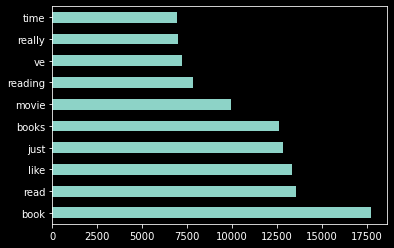

In [54]:
top_10_words(df['selftext'])

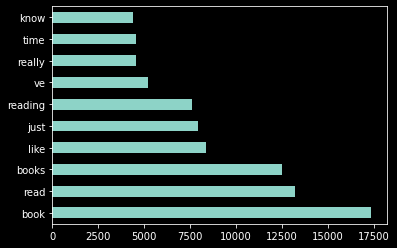

In [55]:
top_10_words(df[df['subreddit']==0]['selftext'])

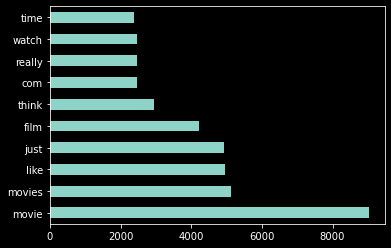

In [56]:
top_10_words(df[df['subreddit']==1]['selftext'])

## Null Model

In [57]:
df['subreddit'].value_counts(normalize=True)

0    0.609581
1    0.390419
Name: subreddit, dtype: float64

Our null model would have an accuracy of 60.9% - we would predict all text to be related to books

## Train Test Split

In [58]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## GridSearch Count Vectorizer

In [25]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])`

In [26]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [27]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1) # 5-fold cross-validation.

In [28]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  7.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [65]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [66]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=2)),
                ('nb', MultinomialNB())])

In [29]:
gs.best

0.9426626751907257


In [30]:
gs.score(X_train, y_train) , gs.score(X_test,y_test)

(0.9491514849014225, 0.9441418619379354)

This is a great improvement over our base model and a very good model since the variance is low and bias is good too.
Since we are trying to classify if its movie or book, we do care about accuracy more than other scores - specificity,sensitivity etc 

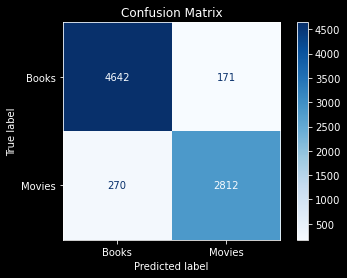

In [71]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion Matrix')
plt.xticks([0,1],['Books','Movies'])
plt.yticks([0,1],['Books','Movies']);

## Decision Trees

In [42]:

from sklearn.feature_extraction import text 
mywords  = ['just','like','time','really']
stop_words = text.ENGLISH_STOP_WORDS.union(mywords)

In [3]:
tvec = TfidfVectorizer()

NameError: name 'stop_words' is not defined

In [ ]:
Z_train = tvec.fit_transform(X_train)
Z_test = tvec.transform(X_test)

In [68]:
dt = DecisionTreeClassifier(random_state = 42)
bag = BaggingClassifier(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
et = ExtraTreesClassifier(random_state = 42)

In [69]:
cross_val_score(dt,Z_train,y_train,cv=5).mean()

0.9057268012492179

In [ ]:
cross_val_score(bag,Z_train,y_train,cv=5).mean()

In [70]:
cross_val_score(rf,Z_train,y_train,cv=5).mean()

KeyboardInterrupt: 

In [ ]:
cross_val_score(et,X_train,y_train,cv=5).mean()

## Random Tree

In [72]:
rf.fit(Z_train,y_train)

RandomForestClassifier(random_state=42)

In [73]:
rf.score(Z_train,y_train), rf.score(Z_test,y_test)

(0.9984402295982031, 0.9346421785940469)

In [59]:
tvec =  TfidfVectorizer(stop_words,max_df=.9, min_df=1)

In [60]:
Z_train = tvec.fit_transform(X_train)
Z_test = tvec.transform(X_test)

In [61]:
rf_grid =  RandomForestClassifier()


In [62]:
rf_params = {
        'n_estimators': [100, 150, 200], # no of trees in the forest
    'max_depth': [3, 4, 5],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto', 'log2']
}

In [63]:
gs_rf = GridSearchCV(rf_grid, param_grid= rf_params, cv= 3,n_jobs = -1, verbose = True)

In [64]:
gs_rf.fit(Z_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 150, 200]},
             verbose=True)

In [74]:
gs_rf.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=7)

In [75]:
gs_rf.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 100}

In [67]:
gs_rf.score(Z_train, y_train),gs_rf.score(Z_test, y_test)

(0.6196655852258548, 0.6173527549081698)

This is obviously not a good model. Only barely better than the base model. So we will be using the Multinomial Naive Nayes with CV